In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tif

In [3]:
from skimage.metrics import structural_similarity, mean_squared_error

In [4]:
from sladsnet.input_params import ERDInputParams, GeneralInputParams, SampleParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.results import Result
from sladsnet.code.base import Sample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.utils import renormalize

###  Step 1: Change the ERD model path and c value as desired. The current script uses the training image 93. The optimal c value for this training model is 2.

Note: I am using pathlib for the paths, but strings should work just fine.

True


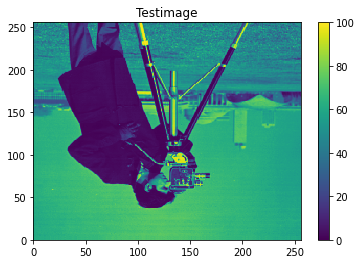

In [5]:

base_path = Path.cwd().parent.parent
train_base_path = base_path / 'ResultsAndData/TrainingData/cameraman/'
train_img_path = train_base_path / 'Images/cameraman_norm.tif'

print(train_img_path.exists())
train_img = tif.imread(train_img_path)

train_img = renormalize(image=train_img)

plt.pcolormesh(train_img)
plt.colorbar()
plt.title('Testimage')
plt.show()

In [6]:
C_VALUE = 2

erd_model = SladsSklearnModel(load_path=train_base_path / f'c_{C_VALUE}/erd_model_relu.pkl')

### Step 2: Set test image path. If we want to save the output to a specific directory, set the output directory, otherwise use none.

Ensure the output directory existsbeforehand. The test image has to be a tif.

In [7]:
test_img_path = 'norm_xrm.tif'
output_save_path = None

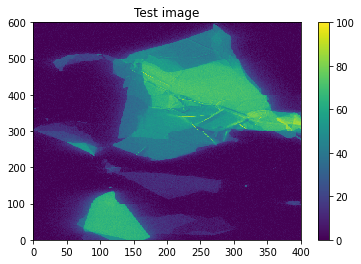

In [8]:
test_img = tif.imread(test_img_path)
test_img = renormalize(np.exp(test_img)**3)

plt.pcolormesh(test_img)
plt.colorbar()
plt.title('Test image')
plt.show()

### Step 3: Set the stop ratio (stop_ratio of 0.1 = 10% sampling, 0.4 = 40% sampling, etc.).

### Step 4: Set the frequency at which to store the sampling masks, reconstructions, and predicted ERDs for later access. 
- These are stored in "result", and saved in a pickle file in the output_save_path if output_save_path is specified. If we don't want to store this, set store_results_percentage to None.

- If store_results_frequency = 1 (for example, then the results are stored after 1% of the sample is measured).

In [9]:
stop_ratio = 0.5
store_results_percentage = 1


affected_neighbors_window_min = 5
affected_neighbors_window_max = 15
full_erd_recalculation_frequency = 50

params_erd = ERDInputParams(c_value=C_VALUE,
                            full_erd_recalculation_frequency=full_erd_recalculation_frequency,
                            affected_neighbors_window_min=affected_neighbors_window_min,
                            affected_neighbors_window_max=affected_neighbors_window_max)

params_gen = GeneralInputParams()

In [10]:
measurement_interface = TransmissionSimulationMeasurementInterface(image=test_img)

if store_results_percentage is None or store_results_percentage == 0:
    results = None
else:
    results = Result()

sample_params = SampleParams(image_shape=measurement_interface.image.shape,
                             initial_scan_ratio=0.01,
                             inner_batch_size=5,
                             stop_ratio=stop_ratio,
                             random_seed=11)
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)

In [11]:
sample.perform_initial_scan()

Text(0.5, 1.0, 'Initial mask')

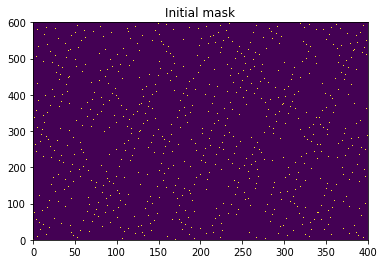

In [12]:
plt.pcolormesh(sample.mask)
plt.title('Initial mask')

In [13]:
measurement_interface = TransmissionSimulationMeasurementInterface(image=test_img)

if store_results_percentage is None or store_results_percentage == 0:
    results = None
else:
    results = Result()

sample_params = SampleParams(image_shape=measurement_interface.image.shape,
                             initial_scan_ratio=0.02,
                             inner_batch_size=5,
                             stop_ratio=stop_ratio,
                             random_seed=11)
sample = Sample(sample_params=sample_params,
                general_params=params_gen,
                erd_params=params_erd,
                measurement_interface=measurement_interface,
                erd_model=erd_model)

In [14]:
sample.perform_initial_scan()

Text(0.5, 1.0, 'Initial mask')

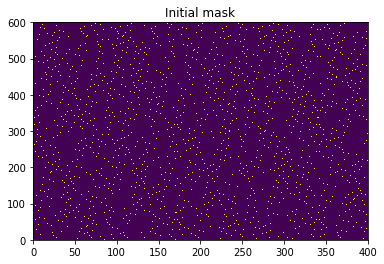

In [15]:
plt.pcolormesh(sample.mask)
plt.title('Initial mask')

### Step 5: Run the sampling 

In [16]:
%%time
run_sampling(sample, results=results, results_frequency_percentage=store_results_percentage, disable_progress_bar=False)

No more improvements expected. Stopping scan.
CPU times: user 32min 56s, sys: 1h 3min 21s, total: 1h 36min 17s
Wall time: 3min 53s


(<sladsnet.code.results.Result at 0x2b89cd6d8610>, 4795)

### Plot the results. 

In [20]:
print(results.size)

12


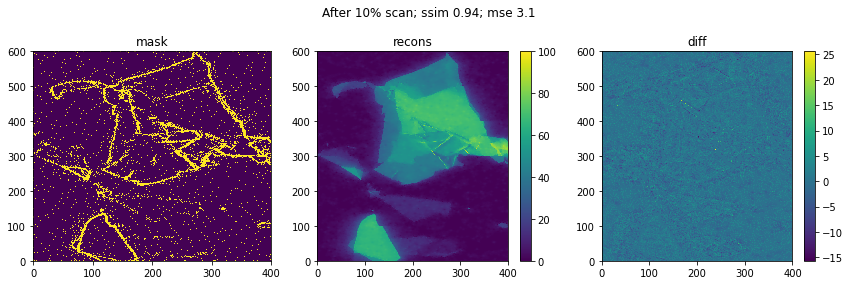

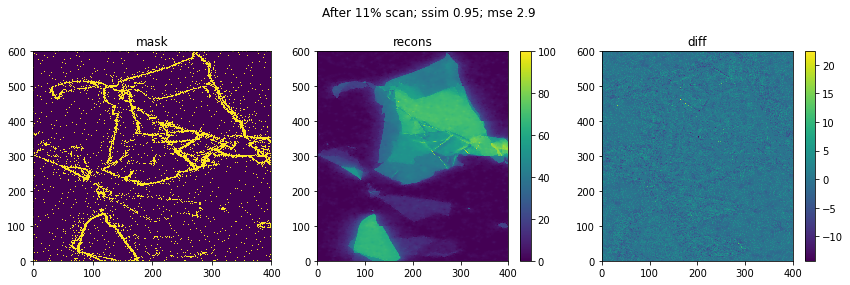

In [24]:
for i in range(2):

    scan_ratio = (i + 1) * 0.1
    percent = int(scan_ratio * 100)
    if percent >= results.size:
        percent = results.size - 1

    fig, axs = plt.subplots(1, 3, figsize=[12, 4])
    plt.subplot(1, 3, 1)
    plt.pcolormesh(results.outputs.masks[percent])
    plt.title('mask')
    plt.subplot(1, 3, 2)
    plt.pcolormesh(results.outputs.recons[percent])
    plt.colorbar()
    plt.title('recons')
    plt.subplot(1, 3, 3)
    err = measurement_interface.image - results.outputs.recons[percent]
    plt.pcolormesh(measurement_interface.image - results.outputs.recons[percent])
    plt.colorbar()
    plt.title('diff')
    
    ssim = structural_similarity(results.outputs.recons[percent], measurement_interface.image, 
                                 data_range=255)
    mse = mean_squared_error(results.outputs.recons[percent], measurement_interface.image)
    
    plt.suptitle(f'After {percent}% scan; ssim {ssim:3.2g}; mse {mse:3.2g}')
    plt.tight_layout()
    plt.show()
